In [3]:
print("hello")

hello


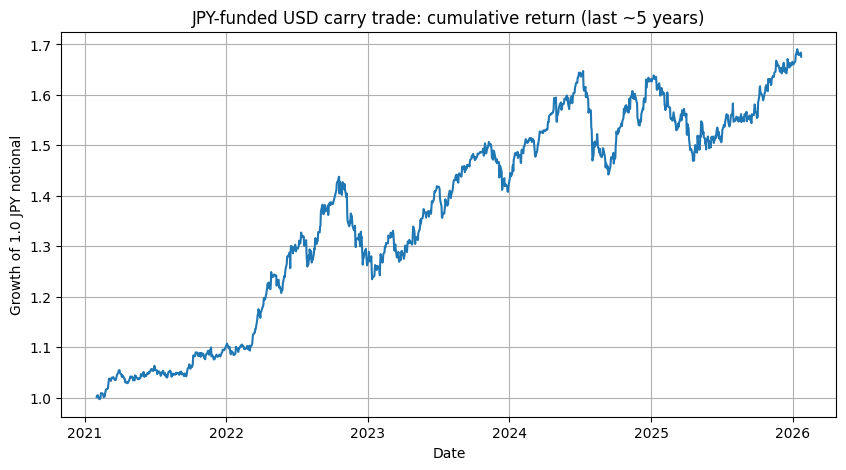

Calendar-year returns (JPY terms):
observation_date
2021     9.88%
2022    14.85%
2023    12.32%
2024    15.07%
2025     2.05%
2026     0.66%
dtype: object


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import date, timedelta

# --- Parameters ---
end = date.today()
start = end - timedelta(days=365*5 + 10)  # ~5y buffer
start_s = start.isoformat()
end_s = end.isoformat()

def fred_csv(series_id, start_date, end_date):
    url = (
        "https://fred.stlouisfed.org/graph/fredgraph.csv"
        f"?id={series_id}&cosd={start_date}&coed={end_date}"
    )
    df = pd.read_csv(url)

    # FRED uses 'observation_date' in this endpoint
    df["observation_date"] = pd.to_datetime(df["observation_date"])
    df = df.set_index("observation_date")

    # Clean missing values and coerce to numeric
    df = df.replace(".", np.nan)
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    return df

# --- Fetch data ---
fx = fred_csv("DEXJPUS", start_s, end_s).rename(columns={"DEXJPUS": "USDJPY"})  # JPY per USD
us = fred_csv("EFFR", start_s, end_s).rename(columns={"EFFR": "r_us"})         # % p.a., daily
jp = fred_csv("IRSTCI01JPM156N", start_s, end_s).rename(columns={"IRSTCI01JPM156N": "r_jp"})  # % p.a., monthly

# --- Align frequencies ---
# Daily calendar from FX (business-day-ish); forward-fill rates.
data = fx.join(us, how="left").join(jp, how="left")
data["r_us"] = data["r_us"].ffill()
data["r_jp"] = data["r_jp"].ffill()

# Drop days where FX is missing (holidays)
data = data.dropna(subset=["USDJPY", "r_us", "r_jp"]).copy()

# --- Carry trade daily return in JPY terms ---
# Use ACT/360 daycount (common for money markets); you can switch to 365 if desired.
dt = 1/360
r_us = data["r_us"] / 100.0
r_jp = data["r_jp"] / 100.0

# FX gross return: S_{t+1}/S_t
fx_gross = data["USDJPY"].shift(-1) / data["USDJPY"]

# Interest gross returns over one day
us_gross = 1 + r_us * dt
jp_gross = 1 + r_jp * dt

gross = fx_gross * (us_gross / jp_gross)

# Last row has no t+1 FX
gross = gross.iloc[:-1]
ret = gross - 1.0

# Cumulative index (start at 1.0)
cum = (1 + ret).cumprod()
cum.name = "JPY-funded long USD carry (cumulative)"

# --- Plot ---
plt.figure(figsize=(10, 5))
plt.plot(cum.index, cum.values)
plt.title("JPY-funded USD carry trade: cumulative return (last ~5 years)")
plt.xlabel("Date")
plt.ylabel("Growth of 1.0 JPY notional")
plt.grid(True)
plt.show()

# Optional: show where the action is (calendar-year returns)
yr = (1 + ret).groupby(ret.index.year).prod() - 1
print("Calendar-year returns (JPY terms):")
print((yr * 100).round(2).astype(str) + "%")
